In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Cargar la data
df = pd.read_csv("taller2_MLE.csv")

In [2]:
df.head()  

edad    segmento  saldo_total  numero_productos  visitas_app_mes  usa_web  \
0    48  Preferente     43791.80                 5               11        0   
1    36    Est√°ndar     17940.87                 1                7        0   
2    48    Est√°ndar      9308.09                 4                3        0   
3    30    Est√°ndar       709.76                 5                5        1   
4    74  Preferente     20471.46                 1                4        0   

   usa_tarjeta_credito  reclamos_6m  satisfaccion_encuesta  \
0                    1            1                    4.2   
1                    1            0                    2.2   
2                    1            1                    1.0   
3                    1            0                    5.0   
4                    0            1                    3.1   

   tasa_credito_personal rango_ingresos  region  cerrara_cuenta  
0                  36.82          Medio  Sierra               0  
1                  39.78       Muy Alto   Selva               0  
2                  28.36          Medio  Sierra               1  
3                  45.73           Bajo   Selva               0  
4                  39.19          Medio  Sierra               0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   edad                   5000 non-null   int64  
 1   segmento               5000 non-null   object 
 2   saldo_total            5000 non-null   float64
 3   numero_productos       5000 non-null   int64  
 4   visitas_app_mes        5000 non-null   int64  
 5   usa_web                5000 non-null   int64  
 6   usa_tarjeta_credito    5000 non-null   int64  
 7   reclamos_6m            5000 non-null   int64  
 8   satisfaccion_encuesta  5000 non-null   float64
 9   tasa_credito_personal  5000 non-null   float64
 10  rango_ingresos         5000 non-null   object 
 11  region                 5000 non-null   object 
 12  cerrara_cuenta         5000 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 507.9+ KB


### **Pregunta 01:**  ¬øCu√°l es el porcentaje de clientes que cerraron su cuenta? ¬øEst√° balanceado el dataset?

In [4]:
df['cerrara_cuenta'].value_counts(normalize=True)*100

cerrara_cuenta
0    85.96
1    14.04
Name: proportion, dtype: float64

##### **Respuesta :** El dataset esta desbalanceado, presenta 14% de clientes con tendencia a cerrar su cuenta.

### **Pregunta 02:** ¬øQu√© variables tienen mayor correlaci√≥n con cerrara_cuenta?

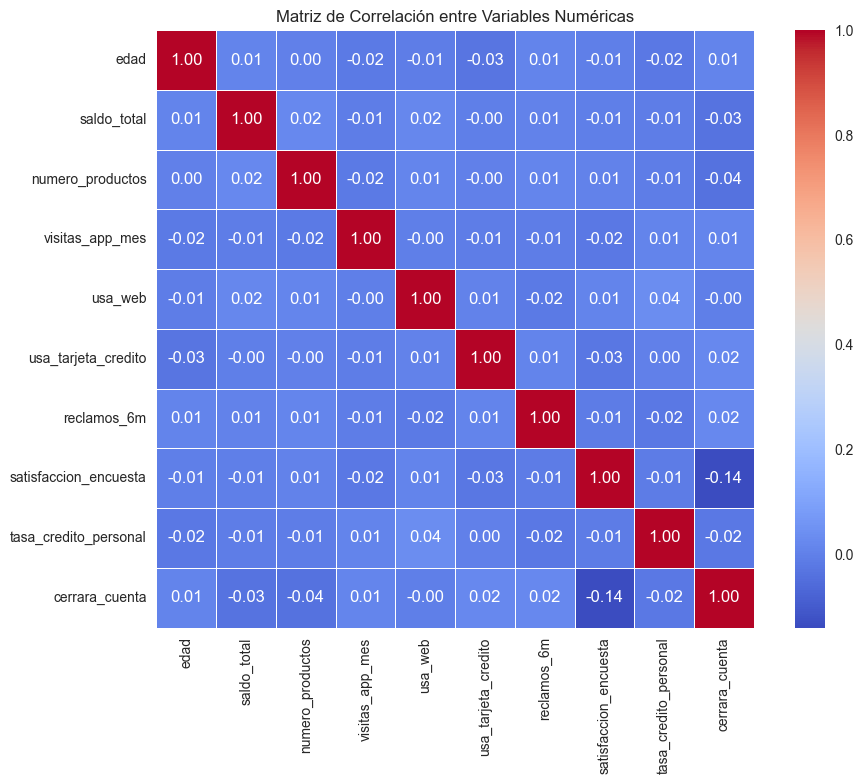

In [5]:
# Filtrar solo variables num√©ricas
numerical_vars = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlaci√≥n
corr_matrix = numerical_vars.corr()

# Crear heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de Correlaci√≥n entre Variables Num√©ricas")
plt.tight_layout()
plt.show()

#### **Respuesta:** Existe una mayor correlaci√≥n negativa entre la satisfacci√≥n del cliente con que el cliente cierre su cuenta.

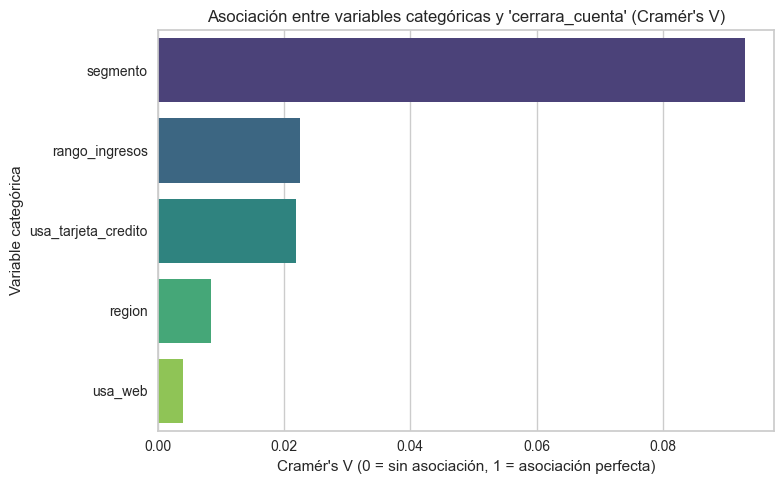

In [6]:
# Funci√≥n para calcular Cram√©r's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Lista de variables categ√≥ricas
cat_vars = ['segmento', 'rango_ingresos', 'region', 'usa_web', 'usa_tarjeta_credito']

# Calcular Cram√©r's V entre cada variable y 'cerrara_cuenta'
cramers_v_values = {}
for var in cat_vars:
    confusion_mat = pd.crosstab(df[var], df['cerrara_cuenta'])
    cramers_v_values[var] = cramers_v(confusion_mat)

# Convertir a DataFrame para graficar
cramer_df = pd.DataFrame.from_dict(cramers_v_values, orient='index', columns=['Cram√©r\'s V']).sort_values(by="Cram√©r's V", ascending=False)

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=cramer_df["Cram√©r's V"], y=cramer_df.index, palette='viridis')
plt.title("Asociaci√≥n entre variables categ√≥ricas y 'cerrara_cuenta' (Cram√©r's V)")
plt.xlabel("Cram√©r's V (0 = sin asociaci√≥n, 1 = asociaci√≥n perfecta)")
plt.ylabel("Variable categ√≥rica")
plt.tight_layout()
plt.show()

#### **Respuesta:** Existe una relaci√≥n positiva entre el segmento con la tendencia a cerrar cuenta.

### **Pregunta 03:** ¬øCu√°l es el mejor modelo en AUC? ¬øY en Recall?

In [7]:
# Discretizaci√≥n manual en 4 bins por cuartiles
df['edad_binned'] = pd.qcut(df['edad'], q=4, labels=False)
df['saldo_total_binned'] = pd.qcut(df['saldo_total'], q=4, labels=False)
df['tasa_credito_binned'] = pd.qcut(df['tasa_credito_personal'], q=4, labels=False)


In [8]:
clf = setup(data=df,
            target='cerrara_cuenta',
            session_id=2025,
            categorical_features=['segmento', 'rango_ingresos', 'region', 'usa_web', 'usa_tarjeta_credito',
                                  'edad_binned', 'saldo_total_binned', 'tasa_credito_binned'],
            transformation=True,
            polynomial_features=True,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85,
            verbose=False)


In [9]:
best_model = compare_models(sort='Recall')

#### **Respuesta :** El modelo que mejor Recall presenta es el de Naive Bayes; mientras que el que mejor AUC presenta es el de Regresi√≥n Log√≠stica. 

### **Pregunta 04:** ¬øQu√© combinaci√≥n de variables permite identificar clientes silenciosos que se van (sin reclamos)?

In [10]:
clientes_silenciosos = df[(df['cerrara_cuenta'] == 1) & (df['reclamos_6m'] == 0)]
clientes_silenciosos.head(3)

edad    segmento  saldo_total  numero_productos  visitas_app_mes  usa_web  \
26    43  Preferente      9200.10                 3                8        1   
47    55    Est√°ndar         0.00                 1                2        1   
49    46    Est√°ndar     35916.27                 4                6        0   

    usa_tarjeta_credito  reclamos_6m  satisfaccion_encuesta  \
26                    0            0                    2.4   
47                    1            0                    3.4   
49                    1            0                    2.7   

    tasa_credito_personal rango_ingresos region  cerrara_cuenta  edad_binned  \
26                  39.72           Bajo  Costa               1            1   
47                  37.96           Bajo  Costa               1            2   
49                  35.12          Medio  Selva               1            1   

    saldo_total_binned  tasa_credito_binned  
26                   0                    2  
47                   0                    2  
49                   3                    1

#### **Respuesta**: La combinaci√≥n de variables que permite identificar aquellos clientes silenciosos es la variable Cerrara_cuenta con la de reclamo_6m. Es decir, cliente que se fueron sin presentar ning√∫n reclamos en los √∫ltimos 6 meses.

### **Pregunta 05:** Qu√© pasa si el modelo predice mal un cliente que no se iba (falso positivo)? ¬øY uno que s√≠ se iba (falso negativo)

Un falso positivo ocurre cuando el modelo se√±ala que un cliente abandonar√° la empresa, pero en realidad no lo har√°. Esto puede llevar a realizar acciones de retenci√≥n innecesarias, generando costos adicionales o incluso incomodidad en el cliente al sentirse presionado sin motivo.
Por otro lado, un falso negativo implica que el modelo no identifica a un cliente que s√≠ tiene intenci√≥n de irse, lo que se traduce en una oportunidad perdida para retenerlo y, por tanto, en una p√©rdida directa para el negocio.
Dado su impacto, los falsos negativos son m√°s cr√≠ticos en este caso, por lo que conviene ajustar el modelo para priorizar una mayor sensibilidad (recall) y as√≠ captar la mayor cantidad posible de clientes en riesgo real de fuga.

### **Pregunta 06:** ¬øQu√© umbral de score (default 0.5 vs optimizado por KS) deber√≠as usar para reducir la p√©rdida financiera?

Aunque el umbral por defecto de 0.5 es com√∫n, no siempre es el m√°s adecuado para reducir p√©rdidas financieras. Este valor clasifica como fuga a cualquier cliente con una probabilidad mayor al 50%, sin considerar el costo de los errores.

En cambio, usar un umbral optimizado mediante el estad√≠stico KS (Kolmogorov-Smirnov) permite identificar el punto donde el modelo separa mejor a los que se van de los que se quedan. Esto ayuda a detectar con mayor precisi√≥n a los clientes en riesgo real, incluso si eso implica asumir m√°s falsos positivos.

Por tanto, para minimizar la p√©rdida financiera por fuga no detectada, se recomienda usar el umbral optimizado por KS, ya que prioriza la sensibilidad del modelo y permite actuar a tiempo con campa√±as de retenci√≥n m√°s efectivas.

### 7. ¬øC√≥mo explicar√≠as con SHAP que un cliente Premium con buen saldo igual fue predicho como fuga? 

In [11]:
df['segmento'].unique()

array(['Preferente', 'Est√°ndar', 'Premium'], dtype=object)

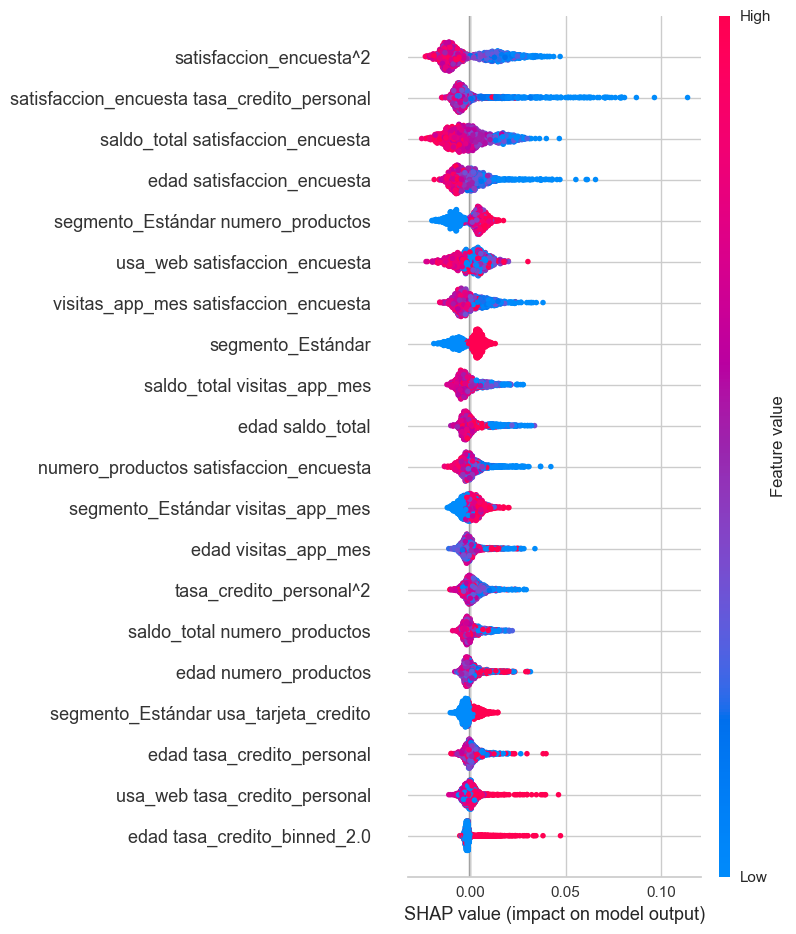

In [12]:
model = create_model('rf')  # Usa Random Forest
interpret_model(model, plot='summary')


Aunque el cliente pertenece al segmento Premium y presenta un buen saldo total, el modelo tambi√©n considera otras variables de mayor peso relativo en la predicci√≥n de fuga.

Seg√∫n el gr√°fico SHAP:

La satisfacci√≥n de la encuesta (satisfaccion_encuesta) y sus interacciones son las variables con mayor impacto. Si este cliente tiene una satisfacci√≥n baja (color azul a la derecha del eje), esto empuja fuertemente la predicci√≥n hacia la fuga.

Tambi√©n influye el uso limitado de canales digitales, como pocas visitas a la app y no usar la web. Esto se ve reflejado en las combinaciones usa_web satisfaccion_encuesta, visitas_app_mes satisfaccion_encuesta, etc. Si este cliente Premium no interact√∫a digitalmente, se interpreta como desinter√©s o desconexi√≥n.

La combinaci√≥n segmento_Est√°ndar y numero_productos tambi√©n tiene peso: aunque el cliente sea Premium, si su n√∫mero de productos contratados es bajo, el valor relacional puede ser d√©bil, lo que inclina la predicci√≥n hacia fuga.

Edad y tasa de cr√©dito aparecen como moderadores importantes. Si el cliente es mayor pero no usa cr√©dito o tiene tasa baja, eso tambi√©n puede contribuir negativamente.

En resumen, el modelo no eval√∫a al cliente solo por el saldo o el segmento, sino por un conjunto de comportamientos y percepciones combinadas. Un cliente Premium con alto saldo pero con baja satisfacci√≥n, poco uso digital y pocos productos contratados ser√° considerado con alta probabilidad de fuga.

### 8. ¬øDeber√≠a el modelo incluir la tasa de inter√©s ofrecida como predictor, si luego esta puede cambiar seg√∫n la pol√≠tica de retenci√≥n? 

Depende del objetivo del modelo. Si el modelo busca predecir la propensi√≥n a la fuga antes de activar cualquier pol√≠tica de retenci√≥n, entonces s√≠ es v√°lido incluir la tasa de inter√©s ofrecida inicialmente, ya que refleja la condici√≥n actual del cliente antes de cualquier intervenci√≥n.

Sin embargo, si el modelo se usar√° para evaluar escenarios despu√©s de aplicar una pol√≠tica de retenci√≥n (por ejemplo, mejorar la tasa ofrecida), entonces:

La tasa de inter√©s se convierte en una variable manipulable.

Incluirla sin control puede generar confusi√≥n o sesgo en las decisiones, especialmente si luego ser√° modificada.

En ese caso, se recomienda:

Tratar la tasa como una variable de intervenci√≥n futura, no como predictor directo.

Usar modelos de what-if o simulaci√≥n para evaluar c√≥mo cambios en la tasa afectar√°n la predicci√≥n de fuga.

### 9. ¬øC√≥mo usar√≠as este modelo en un sistema de reglas mixtas (modelo + regla de  negocio) para que los gestores humanos no pierdan confianza?

Para garantizar que los gestores humanos conf√≠en en el sistema de decisiones mixtas, es clave combinar la predicci√≥n del modelo con reglas de negocio expl√≠citas y comprensibles. Aqu√≠ algunos pasos pr√°cticos:

üîß 1. Definir reglas base claras y aceptadas
Antes de usar el modelo, establece reglas m√≠nimas de elegibilidad o criterios claros que los gestores ya conocen (ej. ‚Äúclientes con saldo > S/10,000 y m√°s de 3 productos no ser√°n marcados como fuga autom√°ticamente‚Äù).

ü§ñ 2. Usar el modelo como alerta, no como mandato
El modelo debe sugerir riesgos, no imponer acciones. Por ejemplo:

‚ÄúCliente con 75% probabilidad de fuga, baja satisfacci√≥n, y no usa la app desde hace 3 meses‚Äù

Esto permite que el gestor tome la decisi√≥n final, usando su criterio.

üß† 3. Explicar la predicci√≥n con SHAP o razones simples
Mostrar al gestor por qu√© el modelo predijo fuga:

‚ÄúSatisfacci√≥n baja‚Äù

‚ÄúNo usa canales digitales‚Äù

‚ÄúMenos de 2 productos contratados‚Äù

Esto aumenta la transparencia y la percepci√≥n de justicia del sistema.

‚öñÔ∏è 4. Permitir la retroalimentaci√≥n humana
Si un gestor considera que el modelo se equivoc√≥, debe poder marcarlo y enviar feedback. Eso:

Mejora el modelo con el tiempo

Aumenta la confianza en el sistema

üìä 5. Medir impactos y mostrar resultados

Demuestra a los gestores que seguir las sugerencias del modelo mejora la retenci√≥n en t√©rminos reales. La evidencia refuerza la confianza.